### Data analysis for DIA-NN's result on SC-Cycle dataset

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use('default')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'Arial'

#### Check analysis time

In [2]:
report_dir = Path('../../reports/SC-Cycle')
with open(report_dir/'diann_220'/'report.log.txt') as f:
    lines = f.readlines()
    time_str = lines[-2].split(' ')[0][1:-1]
    total_minutes = int(time_str.split(':')[0]) + int(
        time_str.split(':')[-1]) / 60
    n = int(lines[-20].split(' ')[-2])
    t_mean = total_minutes / n
print(f'#runs: {n}, Minutes/Run: {t_mean:.2f}')

#runs: 229, Minutes/Run: 9.54


#### Check the report.parquet
1. #ids
2. miss rate

In [3]:
df_raw = pd.read_parquet(report_dir/'diann_220'/'report.parquet', engine='fastparquet')
n_pgs = df_raw[df_raw['Global.PG.Q.Value'] < 0.01]['Protein.Group'].nunique()
n_prs = df_raw[df_raw['Global.Q.Value'] < 0.01]['Precursor.Id'].nunique()
print(f'Global n_pgs: {n_pgs}, Global n_prs: {n_prs}')

Global n_pgs: 3132, Global n_prs: 17067


In [4]:
df_raw['PG.Quantity'] = df_raw['PG.MaxLFQ'].values
df_raw = df_raw[~df_raw['Protein.Group'].str.contains(';')] # groups not in considering

# no local FDR filtering
df1 = df_raw[df_raw['Global.PG.Q.Value'] < 0.01]
df1 = df1[['Protein.Group', 'Run', 'PG.Quantity']]
df1 = df1.drop_duplicates().reset_index(drop=True)
df1 = df1.pivot(index='Protein.Group', columns='Run', values='PG.Quantity')
miss = df1.isna().sum().sum() / df1.shape[0] / df1.shape[1]
print(f'Only Global FDR filtering, shape: {df1.shape}, miss: {miss:.2f}')

# global & local FDR filtering
df2 = df_raw[(df_raw['Global.PG.Q.Value'] < 0.01) & (df_raw['PG.Q.Value'] < 0.01)]
df2 = df2[['Protein.Group', 'Run', 'PG.Quantity']]
df2 = df2.drop_duplicates().reset_index(drop=True)
df2 = df2.pivot(index='Protein.Group', columns='Run', values='PG.Quantity')
miss = df2.isna().sum().sum() / df2.shape[0] / df2.shape[1]
print(f'Local & Global FDR filtering, shape: {df2.shape}, miss: {miss:.2f}')
df2.columns.name = None
df2.index.name = None
df_protein = df2
df_protein.copy()

Only Global FDR filtering, shape: (3078, 229), miss: 0.48
Local & Global FDR filtering, shape: (3077, 229), miss: 0.53


,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_01_S3-G2_1_3873,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_02_S3-G3_1_3874,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_03_S3-G4_1_3875,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_04_S3-G5_1_3876,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_05_S3-G6_1_3877,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_06_S3-G7_1_3878,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_10_S3-G11_1_3882,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_11_S3-G12_1_3883,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_15_S3-H5_1_3888,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_17_S3-H7_1_3890,...,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_86_S5-B2_1_4894,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_87_S5-B3_1_4895,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_88_S5-B4_1_4896,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_90_S5-B6_1_4898,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_92_S5-B8_1_4900,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_93_S5-B9_1_4901,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_94_S5-B10_1_4902,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_95_S5-B11_1_4903,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_96_S5-B12_1_4904,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_98_S5-C2_1_4906
A0AVT1,NaN,8768.788086,2412.275879,3414.790527,8830.140625,7916.306641,2240.763184,8246.836914,10532.092773,NaN,...,NaN,NaN,NaN,NaN,4695.673340,NaN,NaN,3295.76123,NaN,3563.727051
A0FGR8,NaN,NaN,1285.872559,NaN,6754.157227,NaN,NaN,3050.498779,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0MZ66,986.21228,NaN,NaN,NaN,3636.737793,1105.453369,NaN,1635.994995,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1X283,NaN,6739.654297,NaN,2519.188477,14270.836914,8968.746094,NaN,2788.783691,4566.275879,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3606.934326,NaN
A4D1P6,NaN,NaN,NaN,713.819275,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6M1,NaN,2476.926270,NaN,997.232971,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2396.010254
Q9Y6M5,NaN,NaN,NaN,NaN,6618.217773,2189.565918,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1838.30127,NaN,NaN,NaN,NaN,NaN,NaN
Q9Y6N5,NaN,NaN,NaN,1902.367310,3089.493896,9122.097656,2640.185791,4243.596191,2781.922607,2586.014648,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q9Y6V0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,71038.273438,41246.824219,NaN,24519.613281,NaN,29898.876953,NaN,NaN,NaN


#### Convert to cell*protein matrix

In [5]:
df_meta = pd.DataFrame()
df_meta['sample_id'] = 'sample_' + df_raw['Run'].str.split('_').str[-1]
df_meta['treat_id'] = df_raw['Run'].str.split('_').str[-5]
assert set(df_meta['treat_id']) == set(['TB', 'G1', 'G2', 'NB'])
df_meta['treat_id'] = df_meta['treat_id'].replace({'NB': 'G2-M', 'TB': 'G1-S'})
df_meta = df_meta.drop_duplicates().reset_index(drop=True)
df_protein.columns = 'sample_' + df_protein.columns.str.split('_').str[-1]
df_sample = df_protein.T
df_sample = df_sample.merge(df_meta, left_index=True, right_on='sample_id')
df_sample = df_sample.reset_index(drop=True)
df_sample = df_sample[df_sample.columns[::-1]]
df_sample.copy()

,treat_id,sample_id,Q9Y6Y8,Q9Y6V0,Q9Y6N5,Q9Y6M5,Q9Y6M1,Q9Y6K9,Q9Y6K1,Q9Y6K0,...,A6NHQ2,A6NDG6,A5YKK6,A5A3E0,A4FU69,A4D1P6,A1X283,A0MZ66,A0FGR8,A0AVT1
0,G2-M,sample_3873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8783.376953,NaN,NaN,114662.359375,NaN,NaN,NaN,986.212280,NaN,NaN
1,G2-M,sample_3874,3732.786621,NaN,NaN,NaN,2476.926270,4903.024414,NaN,2460.546387,...,29474.822266,7511.246582,4116.859375,760070.750000,NaN,NaN,6739.654297,NaN,NaN,8768.788086
2,G2-M,sample_3875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2587.945557,1683.122314,229997.234375,6116.232422,NaN,NaN,NaN,1285.872559,2412.275879
3,G2-M,sample_3876,5401.528320,NaN,1902.367310,NaN,997.232971,1428.674805,NaN,NaN,...,24483.013672,4880.909180,2020.905518,501577.562500,NaN,713.819275,2519.188477,NaN,NaN,3414.790527
4,G2-M,sample_3877,10498.291992,NaN,3089.493896,6618.217773,NaN,5081.151367,NaN,5188.056152,...,40189.769531,12891.760742,3508.617920,996995.000000,NaN,NaN,14270.836914,3636.737793,6754.157227,8830.140625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,G1,sample_4901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16832.080078,NaN,NaN,159546.593750,NaN,NaN,NaN,NaN,NaN,NaN
225,G1,sample_4902,NaN,29898.876953,NaN,NaN,NaN,NaN,NaN,NaN,...,27421.849609,NaN,NaN,90262.296875,NaN,NaN,NaN,NaN,NaN,NaN
226,G1,sample_4903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3087.101562,NaN,91296.968750,NaN,NaN,NaN,NaN,NaN,3295.761230
227,G1,sample_4904,NaN,NaN,NaN,NaN,NaN,NaN,22681.912109,NaN,...,22999.740234,3344.549316,NaN,178963.265625,NaN,NaN,3606.934326,NaN,NaN,NaN


#### Preprocess
1. drop the high-missingness proteins
2. impute NA with zero
3. normalization
4. log-transformation

##### drop

In [6]:
cut_miss = 0.7
cols_pg = [col for col in df_sample.columns if not col.endswith('_id')]
cols_id = [col for col in df_sample.columns if col.endswith('_id')]
miss_ratio = df_sample[cols_pg].isna().mean()
cols_pg = miss_ratio[miss_ratio <= cut_miss].index.tolist()
df_sample = df_sample[cols_id + cols_pg]
df_sample.copy()

,treat_id,sample_id,Q9Y6K9,Q9Y6K1,Q9Y6G9,Q9Y6E2,Q9Y6E0,Q9Y6B6,Q9Y6A9,Q9Y6A5,...,O00139,O00116,L0R819,E9PRG8,A6NHQ2,A6NDG6,A5YKK6,A5A3E0,A1X283,A0AVT1
0,G2-M,sample_3873,NaN,NaN,2605.813965,7076.818848,3119.607910,1513.860229,7382.763672,1352.692383,...,1658.716064,NaN,NaN,2618.836182,8783.376953,NaN,NaN,114662.359375,NaN,NaN
1,G2-M,sample_3874,4903.024414,NaN,8166.291016,21388.742188,11790.070312,NaN,20707.763672,3476.234131,...,3806.568604,9669.978516,NaN,5616.848633,29474.822266,7511.246582,4116.859375,760070.750000,6739.654297,8768.788086
2,G2-M,sample_3875,NaN,NaN,2594.709961,NaN,3915.852051,NaN,NaN,NaN,...,NaN,3852.014160,NaN,3527.628174,NaN,2587.945557,1683.122314,229997.234375,NaN,2412.275879
3,G2-M,sample_3876,1428.674805,NaN,6183.837402,10261.086914,11497.921875,NaN,6481.026855,NaN,...,NaN,9810.929688,4957.241211,3618.535156,24483.013672,4880.909180,2020.905518,501577.562500,2519.188477,3414.790527
4,G2-M,sample_3877,5081.151367,NaN,15913.895508,22369.052734,10982.473633,7558.746582,23301.728516,15145.703125,...,3769.090576,11505.994141,NaN,10258.766602,40189.769531,12891.760742,3508.617920,996995.000000,14270.836914,8830.140625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,G1,sample_4901,NaN,NaN,3816.311768,NaN,4862.956543,NaN,NaN,NaN,...,NaN,3591.060791,NaN,NaN,16832.080078,NaN,NaN,159546.593750,NaN,NaN
225,G1,sample_4902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3559.323486,NaN,2429.979980,27421.849609,NaN,NaN,90262.296875,NaN,NaN
226,G1,sample_4903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3087.101562,NaN,91296.968750,NaN,3295.761230
227,G1,sample_4904,NaN,22681.912109,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4484.418945,NaN,NaN,22999.740234,3344.549316,NaN,178963.265625,3606.934326,NaN


##### impute

In [7]:
df_sample = df_sample.fillna(0.)
df_sample.copy()

,treat_id,sample_id,Q9Y6K9,Q9Y6K1,Q9Y6G9,Q9Y6E2,Q9Y6E0,Q9Y6B6,Q9Y6A9,Q9Y6A5,...,O00139,O00116,L0R819,E9PRG8,A6NHQ2,A6NDG6,A5YKK6,A5A3E0,A1X283,A0AVT1
0,G2-M,sample_3873,0.000000,0.000000,2605.813965,7076.818848,3119.607910,1513.860229,7382.763672,1352.692383,...,1658.716064,0.000000,0.000000,2618.836182,8783.376953,0.000000,0.000000,114662.359375,0.000000,0.000000
1,G2-M,sample_3874,4903.024414,0.000000,8166.291016,21388.742188,11790.070312,0.000000,20707.763672,3476.234131,...,3806.568604,9669.978516,0.000000,5616.848633,29474.822266,7511.246582,4116.859375,760070.750000,6739.654297,8768.788086
2,G2-M,sample_3875,0.000000,0.000000,2594.709961,0.000000,3915.852051,0.000000,0.000000,0.000000,...,0.000000,3852.014160,0.000000,3527.628174,0.000000,2587.945557,1683.122314,229997.234375,0.000000,2412.275879
3,G2-M,sample_3876,1428.674805,0.000000,6183.837402,10261.086914,11497.921875,0.000000,6481.026855,0.000000,...,0.000000,9810.929688,4957.241211,3618.535156,24483.013672,4880.909180,2020.905518,501577.562500,2519.188477,3414.790527
4,G2-M,sample_3877,5081.151367,0.000000,15913.895508,22369.052734,10982.473633,7558.746582,23301.728516,15145.703125,...,3769.090576,11505.994141,0.000000,10258.766602,40189.769531,12891.760742,3508.617920,996995.000000,14270.836914,8830.140625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,G1,sample_4901,0.000000,0.000000,3816.311768,0.000000,4862.956543,0.000000,0.000000,0.000000,...,0.000000,3591.060791,0.000000,0.000000,16832.080078,0.000000,0.000000,159546.593750,0.000000,0.000000
225,G1,sample_4902,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,3559.323486,0.000000,2429.979980,27421.849609,0.000000,0.000000,90262.296875,0.000000,0.000000
226,G1,sample_4903,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3087.101562,0.000000,91296.968750,0.000000,3295.761230
227,G1,sample_4904,0.000000,22681.912109,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,4484.418945,0.000000,0.000000,22999.740234,3344.549316,0.000000,178963.265625,3606.934326,0.000000


##### normalize

In [8]:
X = df_sample[cols_pg].values
X = 10000 * X / X.sum(axis=1, keepdims=True)
df_sample[cols_pg] = X
df_sample.copy()

,treat_id,sample_id,Q9Y6K9,Q9Y6K1,Q9Y6G9,Q9Y6E2,Q9Y6E0,Q9Y6B6,Q9Y6A9,Q9Y6A5,...,O00139,O00116,L0R819,E9PRG8,A6NHQ2,A6NDG6,A5YKK6,A5A3E0,A1X283,A0AVT1
0,G2-M,sample_3873,0.000000,0.000000,2.142147,5.817602,2.564519,1.244491,6.069108,1.112000,...,1.363572,0.000000,0.000000,2.152852,7.220503,0.000000,0.000000,94.259865,0.000000,0.000000
1,G2-M,sample_3874,0.756544,0.000000,1.260071,3.300315,1.819226,0.000000,3.195239,0.536388,...,0.587359,1.492092,0.000000,0.866688,4.548009,1.158997,0.635238,117.280067,1.039939,1.353037
2,G2-M,sample_3875,0.000000,0.000000,1.400098,0.000000,2.112983,0.000000,0.000000,0.000000,...,0.000000,2.078536,0.000000,1.903498,0.000000,1.396448,0.908208,124.105850,0.000000,1.301657
3,G2-M,sample_3876,0.369215,0.000000,1.598099,2.651790,2.971427,0.000000,1.674903,0.000000,...,0.000000,2.535455,1.281108,0.935144,6.327186,1.261382,0.522266,129.623535,0.651038,0.882490
4,G2-M,sample_3877,0.564140,0.000000,1.766856,2.483547,1.219340,0.839217,2.587098,1.681567,...,0.418467,1.277465,0.000000,1.138990,4.462110,1.431321,0.389548,110.692375,1.584434,0.980375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,G1,sample_4901,0.000000,0.000000,1.889056,0.000000,2.407140,0.000000,0.000000,0.000000,...,0.000000,1.777557,0.000000,0.000000,8.331798,0.000000,0.000000,78.974785,0.000000,0.000000
225,G1,sample_4902,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.680584,0.000000,1.830057,20.651834,0.000000,0.000000,67.977989,0.000000,0.000000
226,G1,sample_4903,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.574950,0.000000,76.150742,0.000000,2.748992
227,G1,sample_4904,0.000000,11.269372,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.228057,0.000000,0.000000,11.427283,1.661719,0.000000,88.916824,1.792084,0.000000


##### log

In [9]:
df_sample[cols_pg] = np.log2(df_sample[cols_pg] + 1.)
df_sample.copy()

,treat_id,sample_id,Q9Y6K9,Q9Y6K1,Q9Y6G9,Q9Y6E2,Q9Y6E0,Q9Y6B6,Q9Y6A9,Q9Y6A5,...,O00139,O00116,L0R819,E9PRG8,A6NHQ2,A6NDG6,A5YKK6,A5A3E0,A1X283,A0AVT1
0,G2-M,sample_3873,0.000000,0.000000,1.651751,2.769264,1.833707,1.166388,2.821528,1.078610,...,1.240969,0.000000,0.000000,1.656658,3.039227,0.000000,0.000000,6.573797,0.000000,0.000000
1,G2-M,sample_3874,0.812740,0.000000,1.176368,2.104442,1.495299,0.000000,2.068753,0.619543,...,0.666629,1.317357,0.000000,0.900481,2.471970,1.110361,0.709500,6.886063,1.028526,1.234524
2,G2-M,sample_3875,0.000000,0.000000,1.263093,0.000000,1.638297,0.000000,0.000000,0.000000,...,0.000000,1.622244,0.000000,1.537792,0.000000,1.260898,0.932219,6.967005,0.000000,1.202673
3,G2-M,sample_3876,0.453349,0.000000,1.377457,1.868604,1.989658,0.000000,1.419486,0.000000,...,0.000000,1.821896,1.189735,0.952441,2.873259,1.177204,0.606220,7.029271,0.723373,0.912642
4,G2-M,sample_3877,0.645370,0.000000,1.468248,1.800557,1.150131,0.879092,1.842817,1.423076,...,0.504333,1.187429,0.000000,1.096930,2.449458,1.281740,0.474616,6.803387,1.369848,0.985774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,G1,sample_4901,0.000000,0.000000,1.530598,0.000000,1.768561,0.000000,0.000000,0.000000,...,0.000000,1.473817,0.000000,0.000000,3.222155,0.000000,0.000000,6.321473,0.000000,0.000000
225,G1,sample_4902,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.879935,0.000000,1.500831,4.436418,0.000000,0.000000,6.108064,0.000000,0.000000
226,G1,sample_4903,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.837923,0.000000,6.269608,0.000000,1.906503
227,G1,sample_4904,0.000000,3.616990,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.690666,0.000000,0.000000,3.635439,1.412359,0.000000,6.490519,1.481342,0.000000


#### PCA
- calculating the silhouette score to check the separation

silhouette score: 0.1969


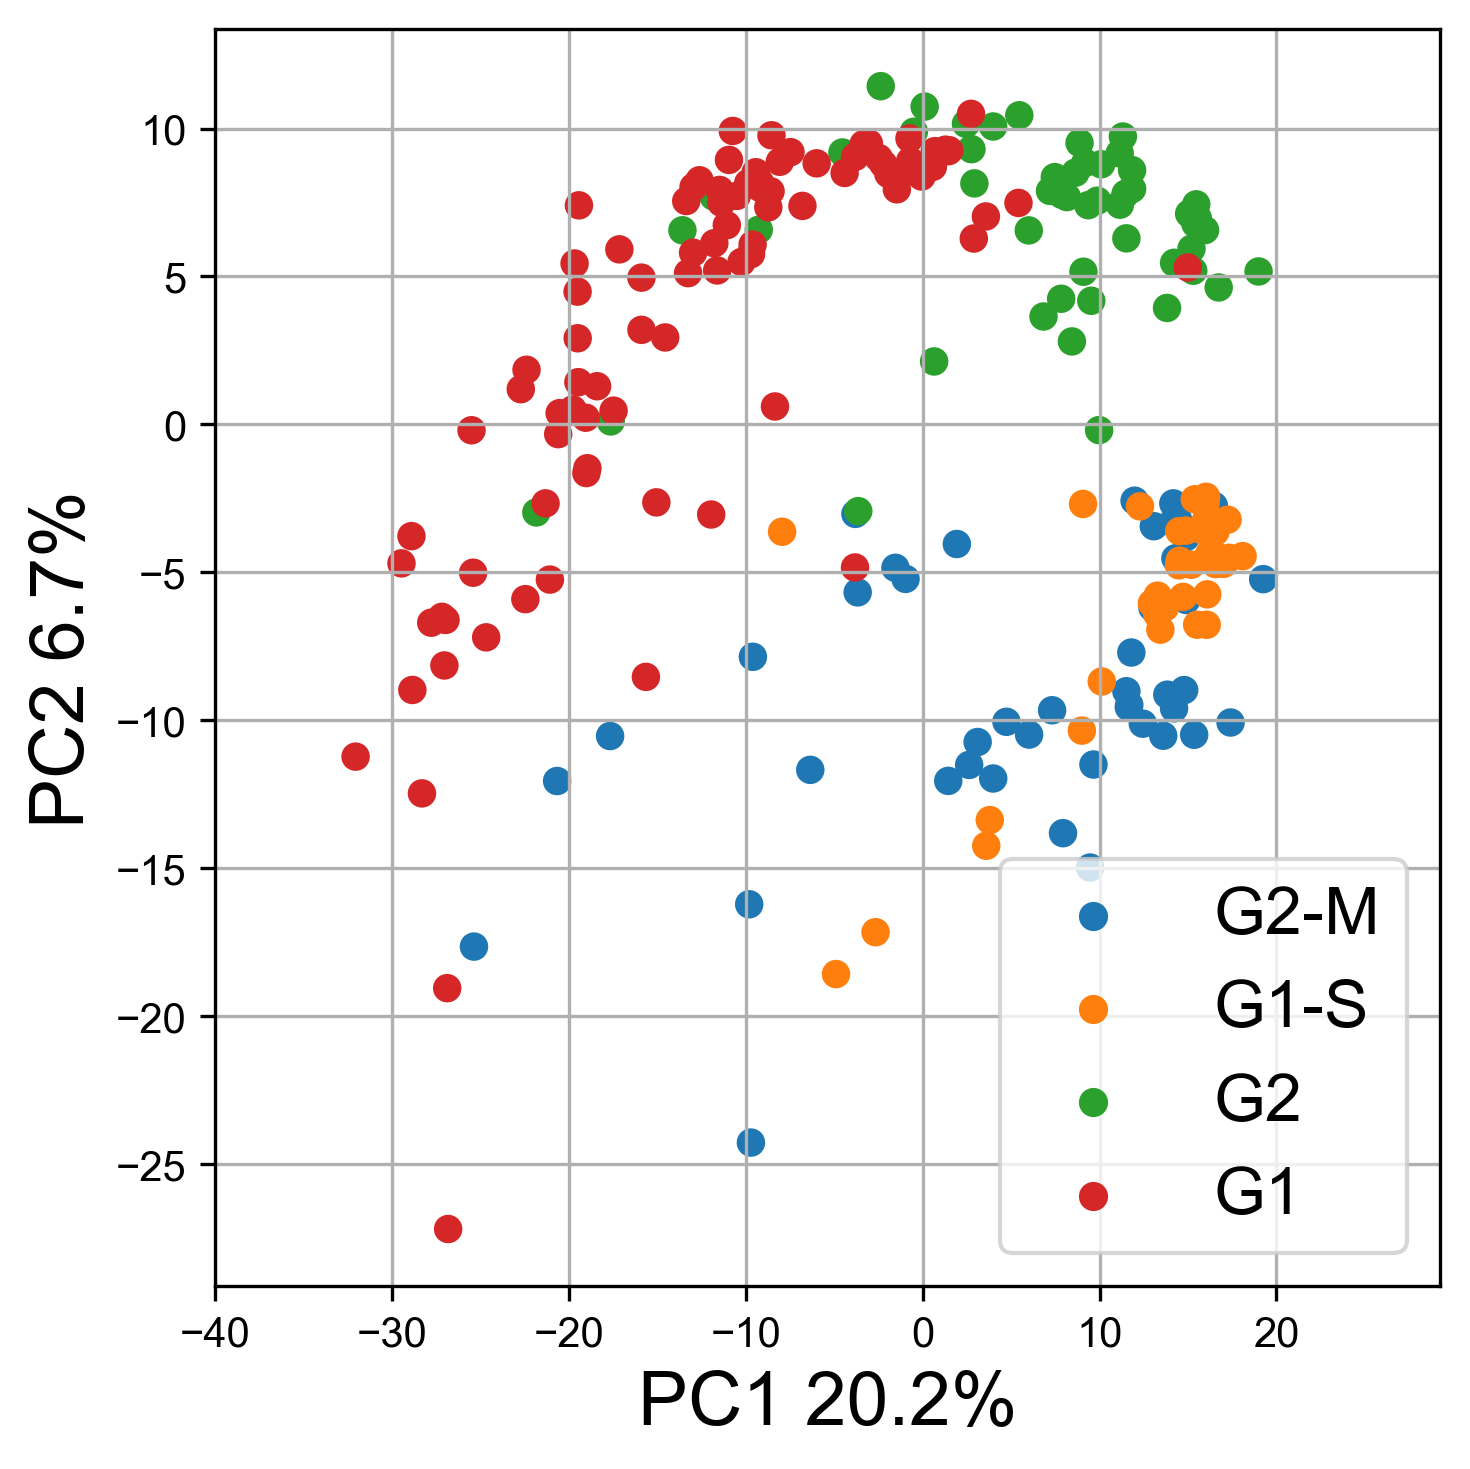

In [10]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

data = df_sample[cols_pg].values
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)

score = silhouette_score(X_pca, df_sample['treat_id'], metric='euclidean')
print(f"silhouette score: {score:.4f}")

df_plot = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'treat_id': df_sample['treat_id'].values
})

plt.figure(figsize=(5, 5))
ax = sns.scatterplot(
    x='PC1', y='PC2', hue='treat_id', data=df_plot,
    s=40,
    edgecolor=None
)
ax.set_xlabel(f'PC1 {pca.explained_variance_ratio_[0] * 100:.1f}%',
              fontsize=18)
ax.set_ylabel(f'PC2 {pca.explained_variance_ratio_[1] * 100:.1f}%',
              fontsize=18)
ax.set_xlim(-40, df_plot['PC1'].max() + 10)
ax.set_ylim(None, None)
ax.grid(True)
plt.legend(title=None, fontsize=16, loc='lower right')
plt.tight_layout()
plt.show()

#### Differential Expression
- G2-M (treat group) vs. G1-S (control group)
- DEP calculation
- Volcano plot

In [11]:
df_sample = df_sample[df_sample['treat_id'].isin(['G1-S', 'G2-M'])].reset_index(drop=True)
n_g2m = sum(df_sample.treat_id == 'G2-M')
n_g1s = sum(df_sample.treat_id == 'G1-S')
print(f'G2-M #cells: {n_g2m}, G1-S #cells: {n_g1s}')
df_sample.copy()

G2-M #cells: 45, G1-S #cells: 41


,treat_id,sample_id,Q9Y6K9,Q9Y6K1,Q9Y6G9,Q9Y6E2,Q9Y6E0,Q9Y6B6,Q9Y6A9,Q9Y6A5,...,O00139,O00116,L0R819,E9PRG8,A6NHQ2,A6NDG6,A5YKK6,A5A3E0,A1X283,A0AVT1
0,G2-M,sample_3873,0.000000,0.0,1.651751,2.769264,1.833707,1.166388,2.821528,1.078610,...,1.240969,0.000000,0.000000,1.656658,3.039227,0.000000,0.000000,6.573797,0.000000,0.000000
1,G2-M,sample_3874,0.812740,0.0,1.176368,2.104442,1.495299,0.000000,2.068753,0.619543,...,0.666629,1.317357,0.000000,0.900481,2.471970,1.110361,0.709500,6.886063,1.028526,1.234524
2,G2-M,sample_3875,0.000000,0.0,1.263093,0.000000,1.638297,0.000000,0.000000,0.000000,...,0.000000,1.622244,0.000000,1.537792,0.000000,1.260898,0.932219,6.967005,0.000000,1.202673
3,G2-M,sample_3876,0.453349,0.0,1.377457,1.868604,1.989658,0.000000,1.419486,0.000000,...,0.000000,1.821896,1.189735,0.952441,2.873259,1.177204,0.606220,7.029271,0.723373,0.912642
4,G2-M,sample_3877,0.645370,0.0,1.468248,1.800557,1.150131,0.879092,1.842817,1.423076,...,0.504333,1.187429,0.000000,1.096930,2.449458,1.281740,0.474616,6.803387,1.369848,0.985774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,G1-S,sample_4077,0.933360,0.0,1.591243,2.330866,1.622080,1.676250,1.803998,1.183341,...,0.662462,1.609529,0.000000,1.564971,3.578379,0.000000,0.571709,4.712266,1.226021,1.037610
82,G1-S,sample_4080,0.756380,0.0,1.270474,1.593944,1.464552,1.153826,0.000000,1.138092,...,0.577794,1.336580,0.967913,0.700090,3.273687,1.281319,0.618669,4.931737,0.839891,1.181944
83,G1-S,sample_4083,0.906823,0.0,1.150769,2.224439,1.614915,0.000000,0.000000,0.000000,...,0.000000,1.494735,0.618150,0.715669,3.357219,0.847574,0.632467,4.765382,0.886601,1.175973
84,G1-S,sample_4086,0.875491,0.0,1.575460,2.087187,1.380943,0.988084,1.378385,0.593532,...,0.592001,1.558296,0.692373,0.954432,3.261697,1.046473,0.675402,5.251653,0.947522,1.011395


In [12]:
# calculating: p, adj p, fc
from scipy import stats
import statsmodels.stats.multitest

pvalues = []
protein_names = []
mean_0_v, mean_1_v = [], []
for pg in cols_pg:
    x_treat = df_sample.loc[df_sample.treat_id == 'G2-M', pg].values
    x_control = df_sample.loc[df_sample.treat_id == 'G1-S', pg].values
    t_val, p_val = stats.ttest_ind(x_treat, x_control, equal_var=False)
    mean_0_v.append(np.mean(x_treat))
    mean_1_v.append(np.mean(x_control))
    pvalues.append(np.float32(p_val))
    protein_names.append(pg)
df_dep = pd.DataFrame({
    'protein_id': protein_names,
    'mean_treat': mean_0_v,
    'mean_control': mean_1_v,
    'pval': pvalues
})
df_dep['pval'] = df_dep['pval'].fillna(np.float32(1))
_, adj_pvals, _, _ = statsmodels.stats.multitest.multipletests(
    df_dep['pval'], alpha=0.05, method="fdr_bh")
df_dep['adj_pval'] = adj_pvals
df_dep['log_fc'] = df_dep['mean_treat'] - df_dep['mean_control']
df_dep.copy()

,protein_id,mean_treat,mean_control,pval,adj_pval,log_fc
0,Q9Y6K9,0.430949,0.597609,0.051977,0.120745,-0.166659
1,Q9Y6K1,0.000000,0.000000,1.000000,1.000000,0.000000
2,Q9Y6G9,1.257402,1.339002,0.405330,0.540823,-0.081601
3,Q9Y6E2,1.649536,1.914151,0.084077,0.172739,-0.264615
4,Q9Y6E0,1.402450,1.399527,0.974854,0.989028,0.002923
...,...,...,...,...,...,...
1879,A6NDG6,1.081614,1.035480,0.663312,0.756392,0.046134
1880,A5YKK6,0.447854,0.519608,0.291056,0.422132,-0.071754
1881,A5A3E0,4.766434,5.787245,0.011553,0.039288,-1.020811
1882,A1X283,0.397234,0.727430,0.000664,0.004794,-0.330196


In [13]:
# assign up and down
cut_fc, cut_p = 0.2, 0.05
df_dep['state'] = 'none'
idx_up = (df_dep['log_fc'] > cut_fc) & (df_dep['adj_pval'] < cut_p)
idx_down = (df_dep['log_fc'] < -cut_fc) & (df_dep['adj_pval'] < cut_p)
df_dep.loc[idx_up, 'state'] = 'up'
df_dep.loc[idx_down, 'state'] = 'down'
n_neg = sum(df_dep['log_fc'] < 0)
n_pos = sum(df_dep['log_fc'] > 0)
n_down = sum(df_dep['state'] == 'down')
n_up = sum(df_dep['state'] == 'up')
print(f'left area: {n_down}/{n_neg}, right area: {n_up}/{n_pos}')
df_dep.copy()

left area: 473/1394, right area: 94/488


,protein_id,mean_treat,mean_control,pval,adj_pval,log_fc,state
0,Q9Y6K9,0.430949,0.597609,0.051977,0.120745,-0.166659,none
1,Q9Y6K1,0.000000,0.000000,1.000000,1.000000,0.000000,none
2,Q9Y6G9,1.257402,1.339002,0.405330,0.540823,-0.081601,none
3,Q9Y6E2,1.649536,1.914151,0.084077,0.172739,-0.264615,none
4,Q9Y6E0,1.402450,1.399527,0.974854,0.989028,0.002923,none
...,...,...,...,...,...,...,...
1879,A6NDG6,1.081614,1.035480,0.663312,0.756392,0.046134,none
1880,A5YKK6,0.447854,0.519608,0.291056,0.422132,-0.071754,none
1881,A5A3E0,4.766434,5.787245,0.011553,0.039288,-1.020811,down
1882,A1X283,0.397234,0.727430,0.000664,0.004794,-0.330196,down


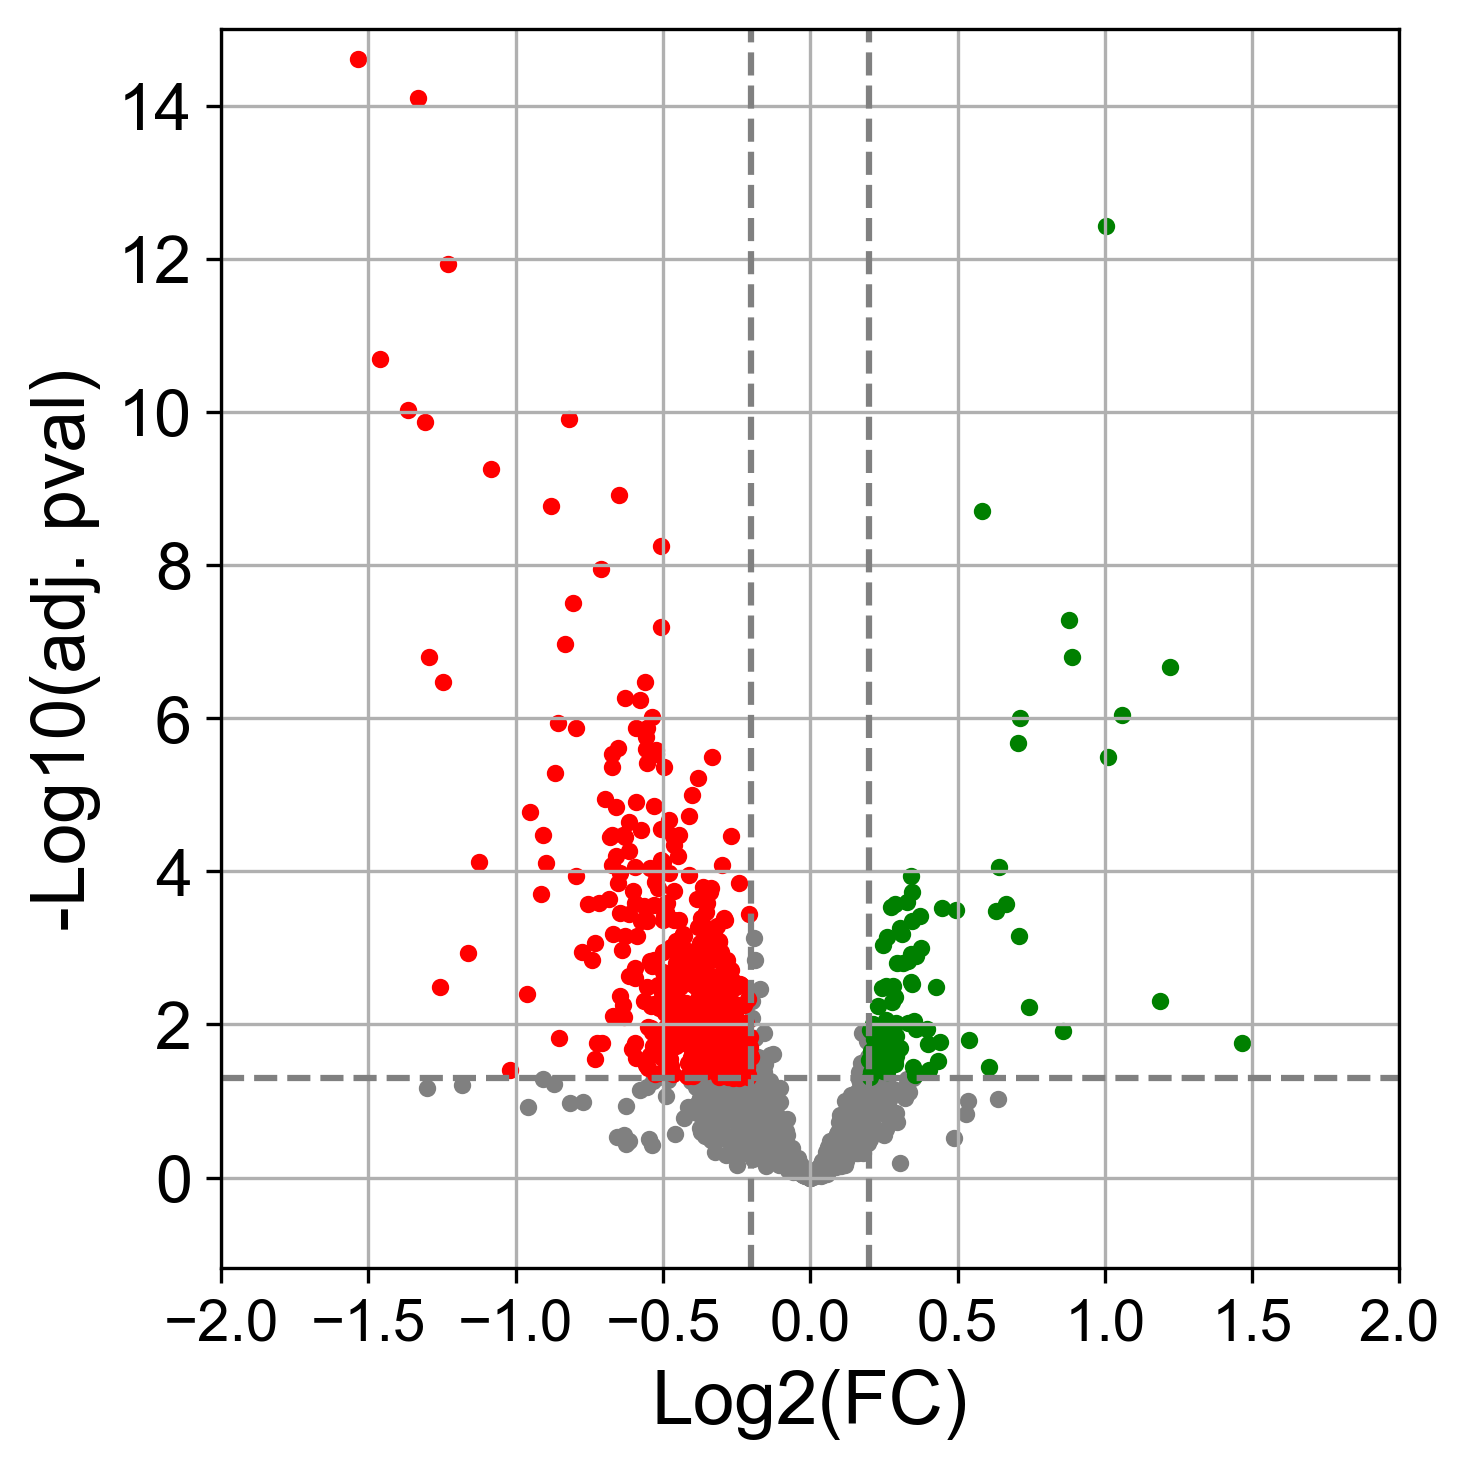

In [14]:
# valcano plot
df_dep['Y'] = -np.log10(df_dep['adj_pval'])
plt.figure(figsize=(5, 5))

df_none = df_dep[df_dep['state'] == 'none']
plt.scatter(x=df_none['log_fc'],
            y=df_none['Y'],
            s=10, label="Not significant", color='grey')

df_up = df_dep[df_dep['state'] == 'up']
df_down = df_dep[df_dep['state'] == 'down']
plt.scatter(x=df_down['log_fc'],
            y=df_down['Y'],
            s=10, color="red")
plt.scatter(x=df_up['log_fc'],
            y=df_up['Y'],
            s=10, color="green")

plt.axvline(cut_fc, color="grey", linestyle="--")
plt.axvline(-cut_fc, color="grey", linestyle="--")
plt.axhline(-np.log10(cut_p), color="grey", linestyle="--")

plt.ylabel("-Log10(adj. pval)", fontsize=18)
plt.xlabel("Log2(FC)", fontsize=18)
plt.xticks(fontweight='light', fontsize=14)
plt.yticks(fontweight='light', fontsize=16)

plt.grid(True)
plt.xlim(-2, 2)
plt.ylim(None, 15)
plt.tight_layout()
plt.show()

#### Pathway Analysis

In [15]:
# pg --> gene
protein_ids, gene_names, is_isoforms = [], [], []
with open(report_dir/'meta'/'swissprot_UP5640_human_20420_20240619.fasta', 'r') as fasta_file:
    for line in fasta_file:
        line = line.strip()
        if line.startswith(">"):
            protein_id = line.split('|')[1]
            gene_name = None
            for field in line.split():
                if field.startswith("GN="):
                    gene_name = field.split("=")[1]
                    break
            protein_ids.append(protein_id)
            gene_names.append(gene_name)
            is_isoforms.append(line.__contains__('isoform'))
df_map = pd.DataFrame({
    "protein_id": protein_ids, "gene": gene_names
})
df_map = df_map.dropna().reset_index(drop=True)
df_gene = pd.merge(df_dep, df_map, on='protein_id')
df_gene.copy()

,protein_id,mean_treat,mean_control,pval,adj_pval,log_fc,state,Y,gene
0,Q9Y6K9,0.430949,0.597609,0.051977,0.120745,-0.166659,none,0.918132,IKBKG
1,Q9Y6K1,0.000000,0.000000,1.000000,1.000000,0.000000,none,-0.000000,DNMT3A
2,Q9Y6G9,1.257402,1.339002,0.405330,0.540823,-0.081601,none,0.266945,DYNC1LI1
3,Q9Y6E2,1.649536,1.914151,0.084077,0.172739,-0.264615,none,0.762611,BZW2
4,Q9Y6E0,1.402450,1.399527,0.974854,0.989028,0.002923,none,0.004791,STK24
...,...,...,...,...,...,...,...,...,...
1879,A6NDG6,1.081614,1.035480,0.663312,0.756392,0.046134,none,0.121253,PGP
1880,A5YKK6,0.447854,0.519608,0.291056,0.422132,-0.071754,none,0.374551,CNOT1
1881,A5A3E0,4.766434,5.787245,0.011553,0.039288,-1.020811,down,1.405745,POTEF
1882,A1X283,0.397234,0.727430,0.000664,0.004794,-0.330196,down,2.319275,SH3PXD2B


Eukaryotic Translation Elongation;Uptake And Function Of Diphtheria Toxin;RHOBTB2 GTPase Cycle;L13a-mediated Translational Silencing Of Ceruloplasmin Expression;GTP Hydrolysis And Joining Of 60S Ribosomal Subunit;Cap-dependent Translation Initiation;Formation Of A Pool Of Free 40S Subunits;Attenuation Phase;Peptide Chain Elongation;Viral mRNA Translation;Eukaryotic Translation Termination;Selenocysteine Synthesis;Nonsense Mediated Decay (NMD) Independent Of Exon Junction Complex (EJC);Selenoamino Acid Metabolism;Folding Of Actin By CCT/TriC


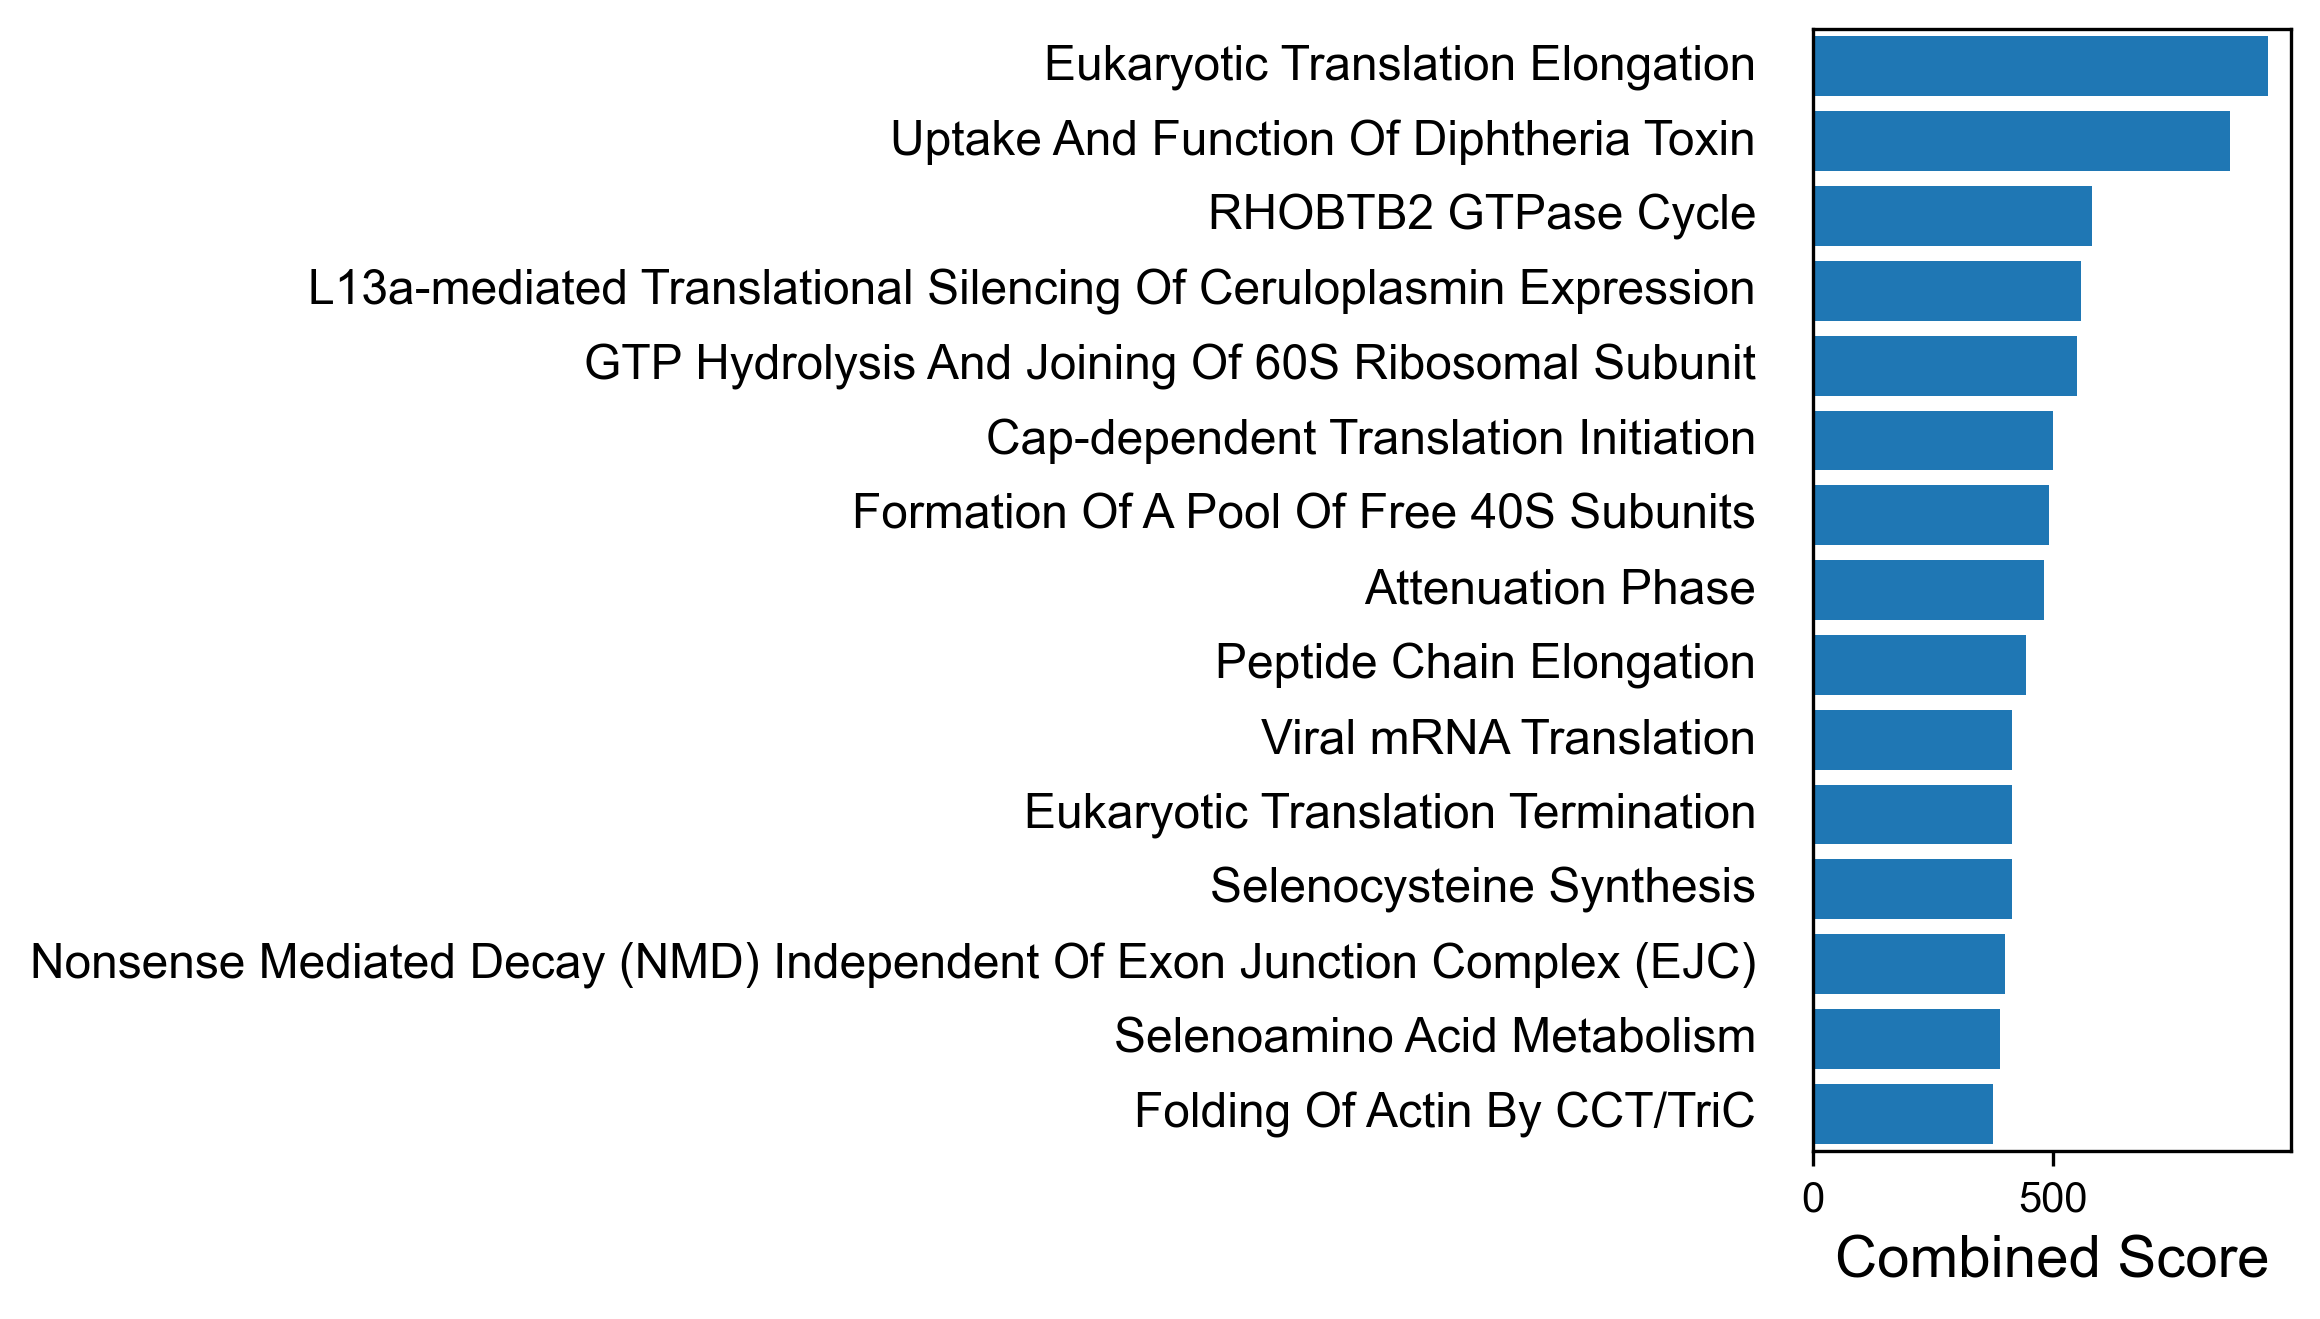

In [16]:
# up pathway enrichment plot
import gseapy as gp
import matplotlib.gridspec as gridspec

n_path = 15

ups = set(df_gene[df_gene['state'] == 'up']['gene'])
enr = gp.enrichr(gene_list=list(ups),
                 gene_sets='Reactome_2022',
                 organism='Human',
                 outdir=None)
df_path = enr.results
df_path = df_path[df_path['Adjusted P-value'] < cut_p]
df_path = df_path.nlargest(n_path, 'Combined Score')

df_path['Term'] = df_path['Term'].str.split(' R-HSA-').str[0]
df_path = df_path.sort_values('Combined Score', ascending=True)
print(df_path['Term'][::-1].str.cat(sep=';'))

terms = df_path['Term'].astype(str).tolist()
scores = df_path['Combined Score'].tolist()
y_pos = np.arange(len(terms))

fig = plt.figure(figsize=(7.5, 4.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1.5])

# Left for terms
ax_text = plt.subplot(gs[0])
ax_text.set_xlim(0, 1)
ax_text.set_ylim(-0.5, len(terms) - 0.5)
ax_text.axis('off')
for i, term in enumerate(terms):
    ax_text.text(1.0, i, term, va='center', ha='right', fontsize=11.5)

# Right for scores
ax_bar = plt.subplot(gs[1])
ax_bar.barh(y_pos, scores)
ax_bar.set_yticks([])
ax_bar.set_ylim(-0.5, len(terms) - 0.5)
ax_bar.set_xlabel('Combined Score', fontsize=14)

plt.tight_layout()
plt.show()